<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2022DataProjectB/blob/main/DataProjectB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
# Patient related data.
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/conditions.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/devices.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/encounters.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/immunizations.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/medications.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/observations.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/patients.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Patient/procedures.csv

In [4]:
# Insurer, payer etc related data.
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Id/organizations.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Id/payers.csv
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/Id/providers.csv

In [5]:
# Data relating payer and patient
!wget -cq https://raw.githubusercontent.com/Fuenfgeld/DMA2022DataProjectB/main/Breast%20Cancer%20Data/payer_transitions.csv

In [220]:
conditions = pd.read_csv("conditions.csv", parse_dates=["START", "STOP"])
devices = pd.read_csv("devices.csv", parse_dates=["START"])
encounters = pd.read_csv("encounters.csv", parse_dates=["START", "STOP"])
immunizations = pd.read_csv("immunizations.csv", parse_dates=["DATE"])
medications = pd.read_csv("medications.csv", parse_dates=["START", "STOP"])
observations = pd.read_csv("observations.csv", parse_dates=["DATE"])

patients = pd.read_csv("patients.csv", parse_dates=["BIRTHDATE", "DEATHDATE"])
patients.rename({"Id": "PATIENT"}, inplace=True)
patients.DEATHDATE.replace(np.nan, "2020-01-01", inplace=True)
patients["AGE"] = patients.DEATHDATE.dt.year - patients.BIRTHDATE.dt.year
# These columns contain almost no entry.
patients = patients.drop(columns = ["MAIDEN", "SUFFIX"])

procedures = pd.read_csv("procedures.csv", parse_dates=["DATE"])

In [7]:
organizations = pd.read_csv("organizations.csv")
payers = pd.read_csv("payers.csv")
providers = pd.read_csv("providers.csv")

In [8]:
payer_transitions = pd.read_csv("payer_transitions.csv", parse_dates=["START_YEAR", "END_YEAR"])

In [221]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 0 to 1018
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   1019 non-null   object        
 1   BIRTHDATE            1019 non-null   datetime64[ns]
 2   DEATHDATE            1019 non-null   datetime64[ns]
 3   SSN                  1019 non-null   object        
 4   DRIVERS              854 non-null    object        
 5   PASSPORT             803 non-null    object        
 6   PREFIX               831 non-null    object        
 7   FIRST                1019 non-null   object        
 8   LAST                 1019 non-null   object        
 9   MARITAL              689 non-null    object        
 10  RACE                 1019 non-null   object        
 11  ETHNICITY            1019 non-null   object        
 12  GENDER               1019 non-null   object        
 13  BIRTHPLACE           1019 non-nul

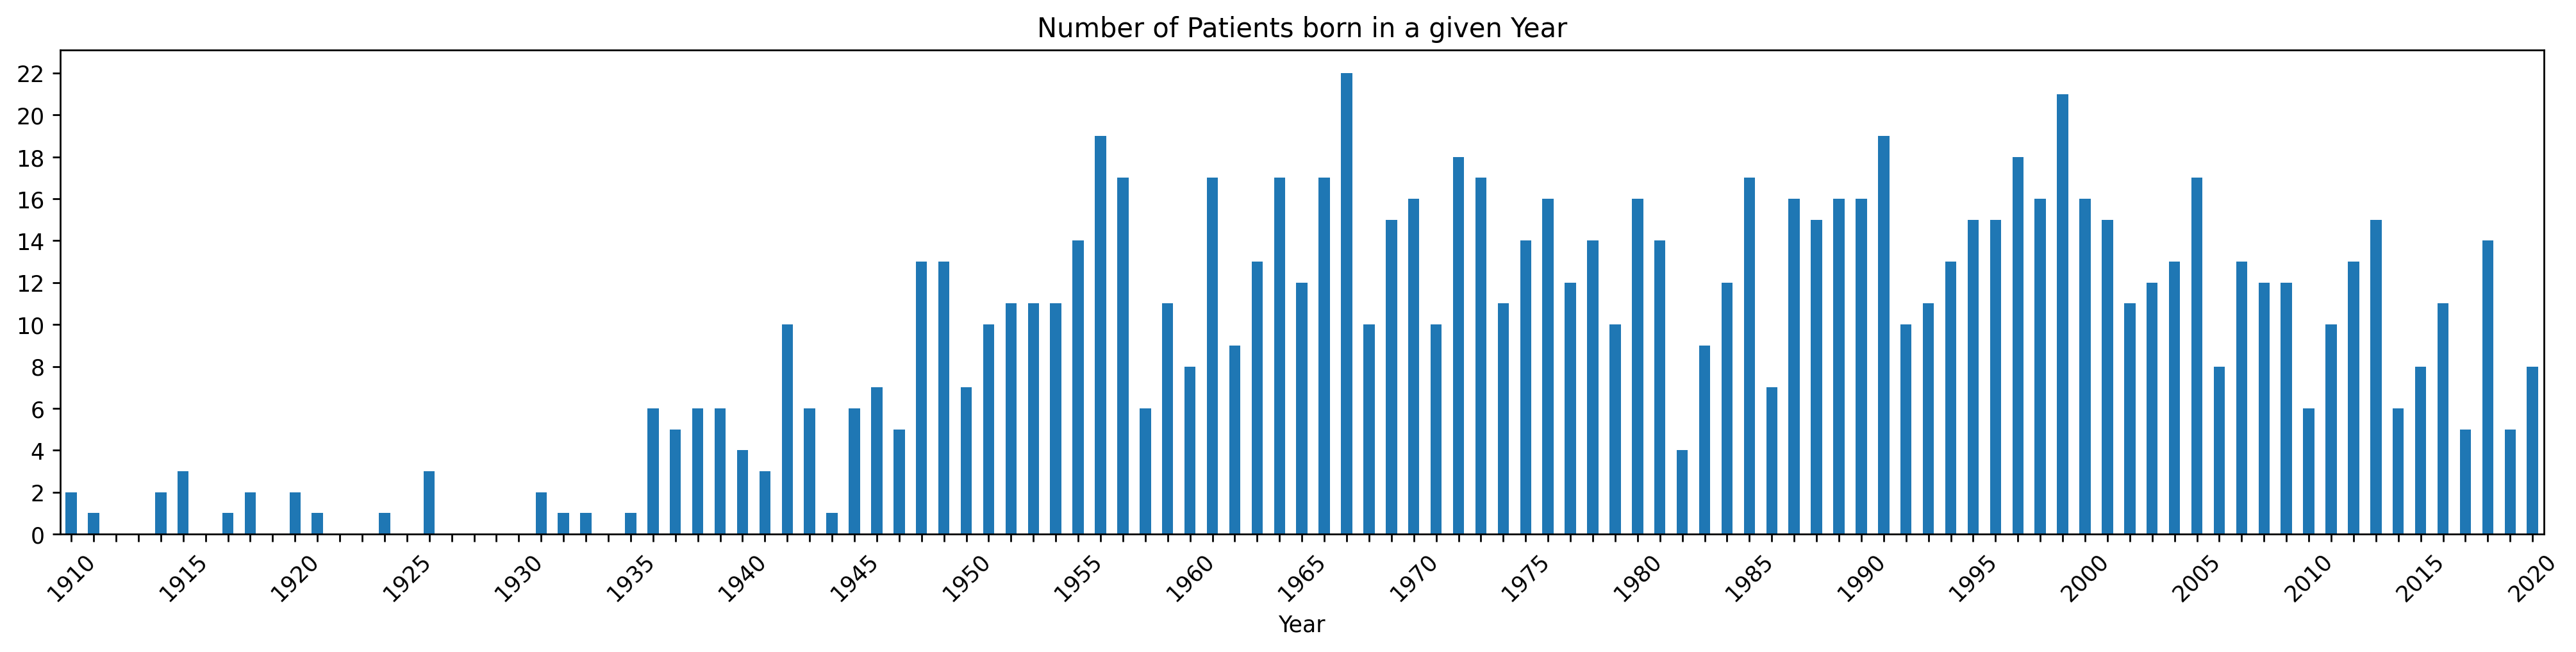

In [184]:
fig, ax = plt.subplots(figsize=(20,4),dpi=250)

# Create DataFrame containing the number of birth dates in every year from 1910 to 2020.
# Not all years have someone born during them. Set the birth counts for those years to zero.
years = pd.DataFrame(data={"DATE": [year for year in range(1910,2021)], "default_counts": np.zeros(2021-1910)}).set_index("DATE")
patients_birthyears = pd.DataFrame(patients.groupby(patients.BIRTHDATE.dt.year).count().BIRTHDATE)

birthyears = (pd.concat([years, patients_birthyears], axis=1).replace(np.nan,0)
                                                             .drop(columns="default_counts"))

# Make plot.
birthyears.BIRTHDATE.plot(kind="bar", ax=ax, rot=45)

for i, label in enumerate(ax.xaxis.get_ticklabels()):
  if i % 5:
    label.set_visible(False)

ax.set_title("Number of Patients born in a given Year")
ax.set_xlabel("Year")
ax.set_yticks([0,2,4,6,8,10,12,14,16,18,20,22])
plt.show()

Text(0.5, 1.0, 'Distribution of Age (YEARS)')

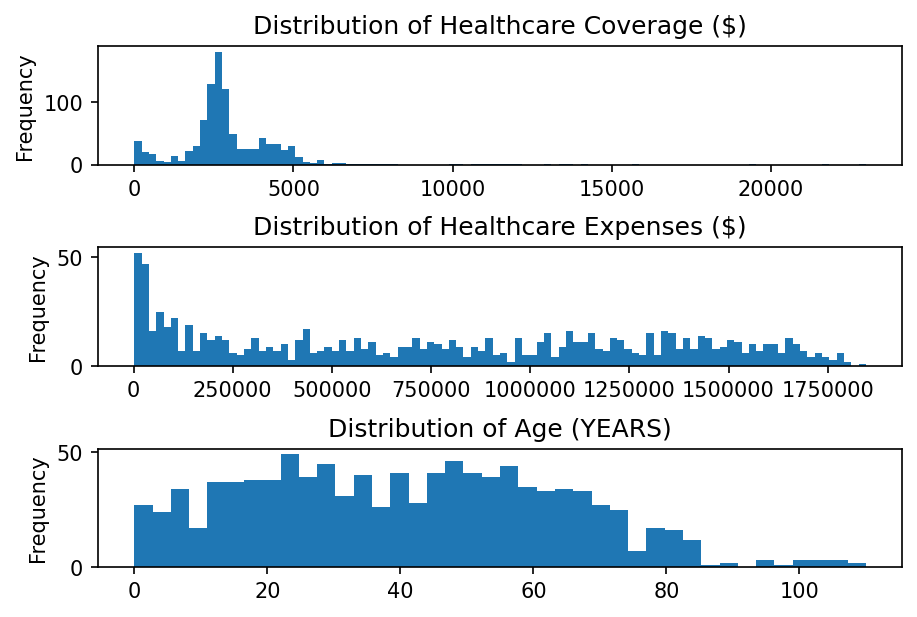

In [227]:
fig, axes = plt.subplots(3, dpi=150, constrained_layout=True)
patients.HEALTHCARE_COVERAGE.plot(kind="hist",ax=axes[0],bins=100)
axes[0].set_title("Distribution of Healthcare Coverage ($)")

patients.HEALTHCARE_EXPENSES.plot(kind="hist", ax=axes[1], bins=100)
axes[1].set_title("Distribution of Healthcare Expenses ($)")
# https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
axes[1].ticklabel_format(style='plain')

patients.AGE.plot(ax=axes[2], kind="hist", bins=40)
axes[2].set_title("Distribution of Age (YEARS)")

In [230]:
per_race = (patients.groupby("RACE").agg({"Id":"count",
                                          "AGE": ["mean", "std"],
                                          "HEALTHCARE_COVERAGE": ["mean","std"],
                                          "HEALTHCARE_EXPENSES": ["mean", "std"]})
                                     .round()
                                     .replace(np.nan,0))

per_race.head()

Id   AGE       HEALTHCARE_COVERAGE         HEALTHCARE_EXPENSES  \
       count  mean   std                mean     std                mean   
RACE                                                                       
asian     59  43.0  25.0              3384.0  2376.0            828814.0   
black     89  41.0  21.0              2851.0  1371.0            710143.0   
native     3  31.0  10.0              2460.0   188.0            746863.0   
other      1  84.0   0.0              5449.0     0.0           1543980.0   
white    867  40.0  23.0              3112.0  2106.0            781962.0   

                  
             std  
RACE              
asian   593881.0  
black   569608.0  
native  243191.0  
other        0.0  
white   551953.0